# Image Loading and Preprocessing using a DataFrame

This example demonstrates how to create a Tensorflow Datasets using images and labels derived from a Pandas DataFrame. The code below relies on the publically-available [PADCHEST dataset](https://bimcv.cipf.es/bimcv-projects/padchest/). The dataset is a collection of frontal and lateral chest x-rays.

To execude code with minimal changes, download sample images and the associated metadata CSV file and extract all files into `padchest` directory.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import TFImageDataset

%config InlineBackend.figure_format = 'retina'

Let's import the metadata file into a DataFrame and create `normal` and `abnormal` labels:

In [60]:
metadata = pd.read_csv('padchest/chest_x_ray_images_labels_sample.csv')
label = [value.find('normal')<0 for value in metadata['Labels'].values]
label = np.array(label)
label = np.where(label, 'abnormal', 'normal')

In [61]:
dataframe = pd.DataFrame({'filename': metadata['ImageID'].values,
                          'label': label})

Now create a `TFImageDataset` object, specifying the directory where individual images are located. `flow_from_dataframe` method with by default ensure that images are present in the specified directory and return an error if otherwise.

In [62]:
dataset = TFImageDataset()
padchest = dataset.flow_from_dataframe(dataframe,
                                       directory='padchest',
                                       x_col='filename',
                                       y_col='label',
                                       classes=['normal', 'abnormal'])

Missing images: 0


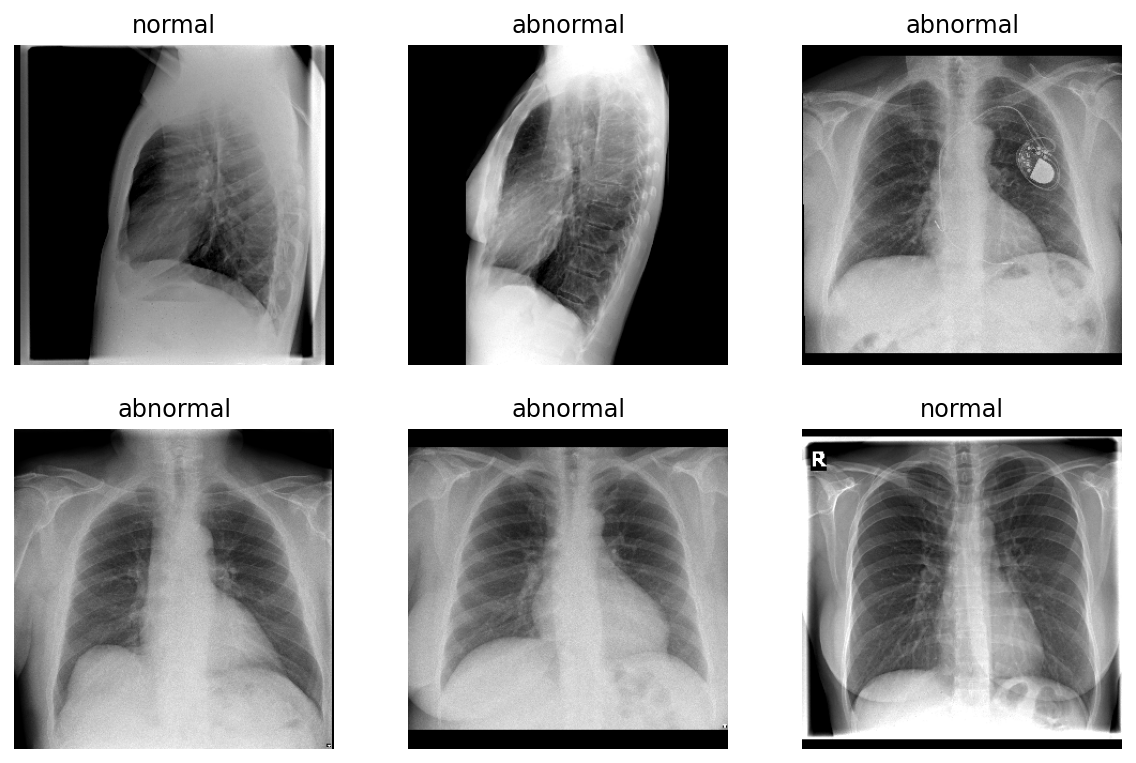

In [63]:
image_batch, label_batch = next(iter(padchest))
class_names = ['normal', 'abnormal']

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = np.argmax(label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

## Custom Image Read Functions

In [31]:
import tensorflow as tf

In [32]:
def read_png(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (299, 299), method='nearest')
    image = tf.cast(image, tf.float32)
    return image

In [33]:
dataset = TFImageDataset(read_function=read_png)
padchest = dataset.flow_from_dataframe(dataframe,
                                       directory='padchest',
                                       x_col='filename',
                                       y_col='label',
                                       classes=['normal', 'abnormal'])

Missing images: 0


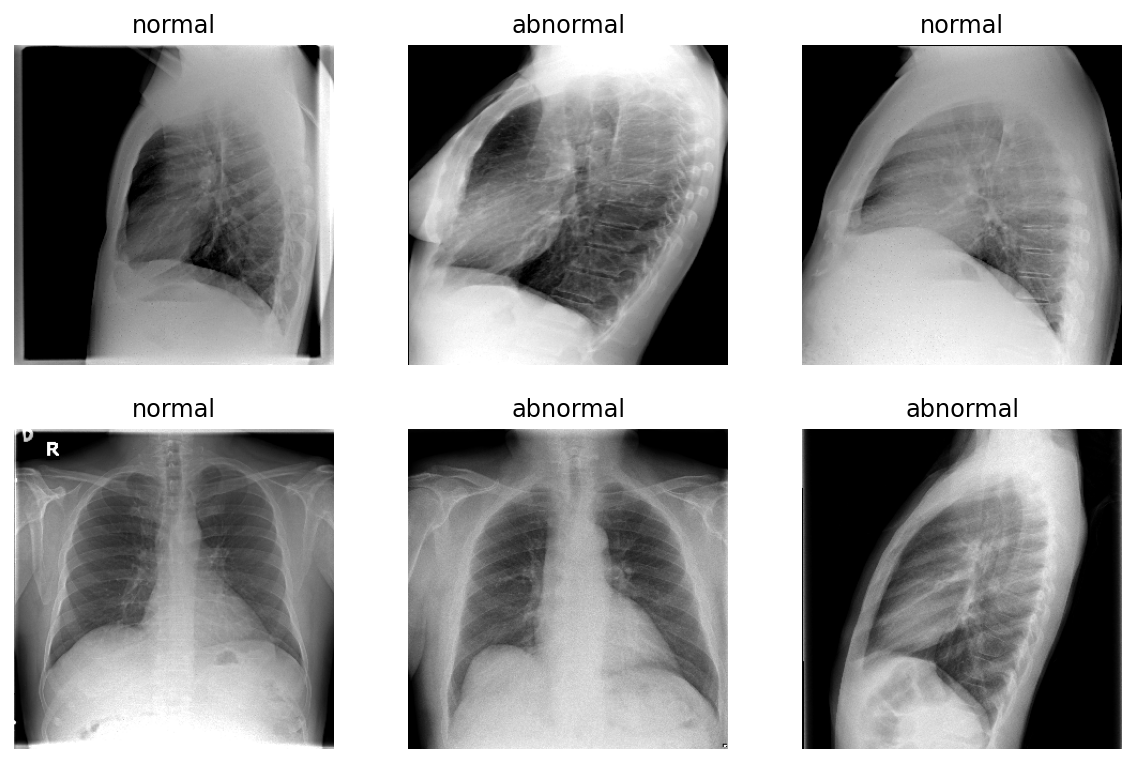

In [34]:
image_batch, label_batch = next(iter(padchest))
class_names = ['normal', 'abnormal']

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = np.argmax(label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

## Built-in read functions

In [35]:
from datasets.io.read_image.read_png import read_png_uint8

In [36]:
dataset = TFImageDataset(read_function=read_png_uint8)
padchest = dataset.flow_from_dataframe(dataframe,
                                       directory='padchest',
                                       x_col='filename',
                                       y_col='label',
                                       classes=['normal', 'abnormal'])

Missing images: 0


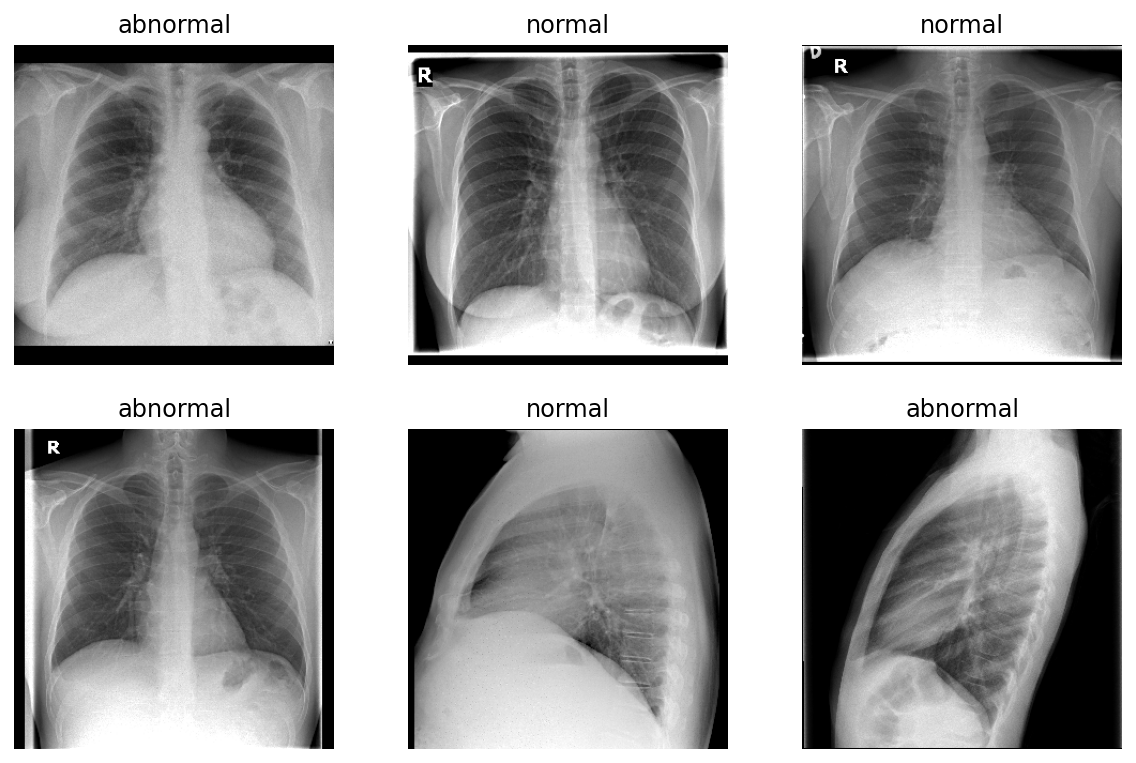

In [37]:
image_batch, label_batch = next(iter(padchest))
class_names = ['normal', 'abnormal']

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = np.argmax(label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

## Multi-input dataset reading

In [10]:
import tensorflow as tf

In [65]:
metadata = pd.read_csv('padchest/chest_x_ray_images_labels_sample.csv')
label = [value.find('normal')<0 for value in metadata['Labels'].values]
label = np.array(label)
label = np.where(label, 'abnormal', 'normal')

In [66]:
dataframe = pd.DataFrame({'input_1': metadata['ImageID'].values,
                          'input_2': metadata['ImageID'].values,
                          'label': label})

In [76]:
def read_multi_png(path):
    output = []
    for key in path.keys():
        image = tf.io.read_file(path[key])
        image = tf.image.decode_png(image, channels=3)
        image = tf.cast(image, tf.float32)
        output.append(image)
    
    return tuple(output)

In [81]:
dataset = TFImageDataset(read_function=read_multi_png)
padchest = dataset.flow_from_dataframe(dataframe,
                                       directory='padchest',
                                       x_col=['input_1', 'input_2'],
                                       y_col='label',
                                       classes=['normal', 'abnormal'],)

Missing images: 0


In [82]:
image_batch, label_batch = next(iter(padchest))
class_names = ['normal', 'abnormal']
x_cols = ['input_1', 'input_2']

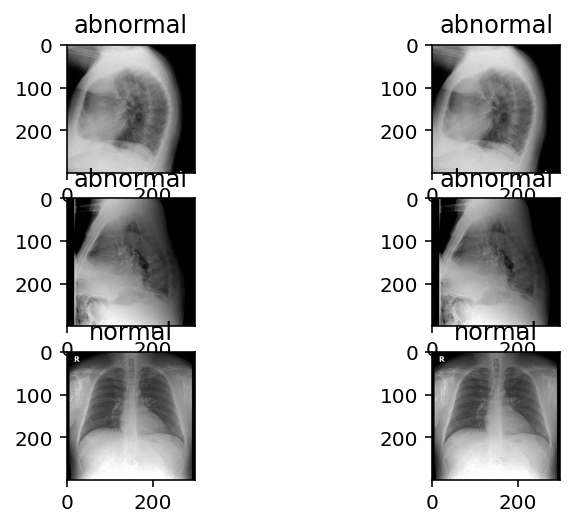

<Figure size 720x720 with 0 Axes>

In [84]:
fig, axs = plt.subplots(3, 2)
plt.figure(figsize=(10, 10))
for i, key in enumerate(x_cols):
    images = image_batch[key].numpy().astype("uint8")
    for j in range(3):
        axs[j, i].imshow(images[j])
        label = np.argmax(label_batch[j])
        axs[j, i].set_title(class_names[label])

## Augmentation Image Dataset Creation

`tensorflow-addons` package versioning is temperamental and is strongly linked to `tensorflow` version itself. This notebook uses `tensorflow` 2.2.0 and therefore requires `tensorlfow-addons` 0.10.0

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
tfa.__version__

Now let's try something more challenging and apply a set of data augmentation steps. Note that 90-degree rotation is applied to images with 50% probability.

**NOTE:** Random choice should be set through the `tf.random.uniform` function

In [ ]:
def augment(image):
    image = tf.image.random_brightness(image, max_delta=0.5)
    rotate = tf.random.uniform([]) > 0.5
    if rotate:
        image = tf.image.rot90(image)
    
    invert = tf.random.uniform([]) > 0.5
    if invert:
        image = 255 - image
    
    return image

In [ ]:
dataset = TFImageDataset(augmentation_function=augment)
padchest = dataset.flow_from_dataframe(dataframe,
                                       directory='padchest',
                                       x_col='filename',
                                       y_col='label',
                                       classes=['normal', 'abnormal'],
                                       batch_size=6,
                                       repeat=False, shuffle=True)

In [ ]:
image_batch, label_batch = next(iter(padchest))
class_names = ['normal', 'abnormal']

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = np.argmax(label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

## Train a simple model

The `TFImageDataset` can now be used directly with the Tensorflow Model object. Let's train InceptionV3 model on this tiny datasets - it's an overkill, but a good illustration of how various features of the `TFImageDataset` class work.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
    preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
def augment(image):
    image = tf.image.random_brightness(image, max_delta=0.5)
    rotate = tf.random.uniform([]) > 0.5
    if rotate:
        image = tf.image.rot90(image)
    
    invert = tf.random.uniform([]) > 0.5
    if invert:
        image = 255 - image
    
    image = tf.cast(image, tf.dtypes.float32)
    return image

In [ ]:
BATCH = 6
IMG_WIDTH = 299
IMG_HEIGHT = 299
LEARNING_RATE = 0.001

In [ ]:
dataset = TFImageDataset(augmentation_function=augment,
                         preprocessing_function=preprocess_input,
                         prefetch_gpu=False)

padchest = dataset.flow_from_dataframe(dataframe,
                                       directory='padchest',
                                       x_col='filename',
                                       y_col='label',
                                       classes=['normal', 'abnormal'],
                                       batch_size=BATCH,
                                       target_size=(IMG_WIDTH, IMG_HEIGHT),
                                       repeat=True, shuffle=True)

In [ ]:
base_model = InceptionV3(include_top=False, pooling='avg')
x = base_model.output
x = Dense(1024, activation='relu')(x)
probas = Dense(2, activation='softmax')(x)
model = Model(base_model.input, probas)


loss_fn = CategoricalCrossentropy()
optimizer = Adam(LEARNING_RATE)

model.compile(loss=loss_fn, optimizer=optimizer,
              experimental_run_tf_function=False,
              metrics=['accuracy'])

STEP_SIZE_TRAIN=dataframe.shape[0]//BATCH

In [ ]:
model.fit(padchest,
          epochs=3,
          steps_per_epoch=STEP_SIZE_TRAIN)